# Demo model applied to CIFAR-10
Dataset https://www.cs.toronto.edu/~kriz/cifar.html

We use only the 1st batch of CIFAR-10 dataset: 10000 images 32x32x3 and 10 labels.

### Load dependencies

In [1]:
import os
import tarfile
import pickle
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
import operator
import mxnet as mx
import logging

### Prepare training and test datasets
`download_data` downloads data from a given `url`, if no file with the same name has been downloaded so far,  
`prepare_img` transforms 3 channels (rgb) to one channel (their mean value), reshapes data, adding one axis of length 1 and normalizes the entries to [0,1],  
`read_CIFAR10` creates labels and datasets from the corresponding "batch" files (see [CIFAR dataset description](https://www.cs.toronto.edu/~kriz/cifar.html))

With these functions we download data from CIFAR web page, create training/test datasets/labels and then split them into batches of size 150 (shuffle for training).  
Dataset gets the name `'data'`, labels - `'label'`

In [2]:
def download_data(url, force_download=True): 
    fname = url.split("/")[-1]
    
    if force_download or not os.path.exists(fname):
        urllib.request.urlretrieve(url, fname)
        
    return fname


def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
        
    return dict


def read_CIFAR10():
    url = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
    tar = tarfile.open(download_data(url, False))
    tar.extractall()
    tar.close()
    
    dict_1 = unpickle("cifar-10-batches-py/data_batch_1")
    
    train_img = dict_1[b'data'].reshape(10000, 3, 1024)
    train_img = train_img.transpose(0,2,1)
    train_lbl = np.array(dict_1[b'labels'])
    
    dict_test_1 = unpickle("cifar-10-batches-py/test_batch")
       
    test_img = dict_test_1[b'data'].reshape(10000, 3, 1024)
    test_img = test_img.transpose(0,2,1)
    test_lbl = np.array(dict_test_1[b'labels'])

    return train_img, train_lbl, test_img, test_lbl


def prepare_img(img):
    # mean across rgb
    img = np.mean(img, -1)
    
    # normalize
    img = img.astype(np.float32) / 255
    
    # reshape to 4-D
    img = img.reshape(img.shape[0], 1, 32, 32)
    
    return img

In [6]:
train_img, train_lbl, test_img, test_lbl = read_CIFAR10()

train_img = prepare_img(train_img)
test_img  = prepare_img(test_img)

batch_size = 150

train_data_iter = mx.io.NDArrayIter(data={'data': train_img}, label= {'label': train_lbl}, batch_size=batch_size, shuffle=True)
test_data_iter  = mx.io.NDArrayIter(data={'data': test_img}, label= {'label': test_lbl}, batch_size=batch_size)

Load and print label names:

In [4]:
def load_classes():
    path = 'cifar-10-batches-py/'
    file = 'batches.meta'
    
    f = open(path+file, 'rb')
    dict = pickle.load(f)
    return dict['label_names']

def print_classes(label_names):
    for i in range(0, 10):
        print(str(i) + " : " + label_names[i] + "  ")

label_names = load_classes()
print_classes(label_names)

0 : airplane  
1 : automobile  
2 : bird  
3 : cat  
4 : deer  
5 : dog  
6 : frog  
7 : horse  
8 : ship  
9 : truck  


### Display example training data

The original Fashion-MNIST consists of 28x28 grayscale images.

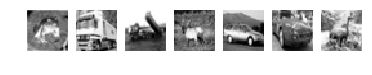

labels: [6 9 9 4 1 1 2]
('frog', 'truck', 'truck', 'deer', 'automobile', 'automobile', 'bird')


In [7]:
pict_number = 7

for i in range(pict_number):
    plt.subplot(1,pict_number,i+1)
    #dsp_img = train_img[i].reshape(32,32,3)
    dsp_img = train_img[i].reshape(32,32)
    #plt.imshow(dsp_img)
    plt.imshow(dsp_img, cmap = "Greys_r")
    plt.axis('off')

plt.show()

print('labels: %s' % (train_lbl[0:pict_number],))
print(operator.itemgetter(*train_lbl[0:pict_number])(label_names))

### Build MXNet model

For building our NN we will use Symbol API, an interface for symbolic programming.

First, we create two placeholders for labels and data inputs with `mx.sym.Variable` and give them names`'fashion_item_label'` and `'fashion_data'` correspondingly. On the next step the data will be flatten to 2-D.

In [8]:
label = mx.sym.Variable('label')

# input
data = mx.symbol.Variable('data')

# Flatten the data from 4-D shape into 2-D (batch_size, num_channel*width*height)
data = mx.sym.flatten(data=data, name='flatten')

`Symbol` also supports a rich set of neural network layers. The folowing code constructs a 3-layer fully connected neural network with the 1st hidden layer having 128 neurons, the 2nd hidden layer having 64 neurons, both activated by ReLU activation function and softmax output layer `mlp`.

Then we visualize the structure of that network with `mx.viz.plot_network`.

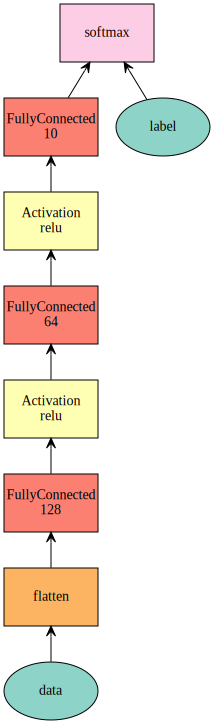

In [9]:
# 1st fully-connected layer + activation function
fc1  = mx.sym.FullyConnected(data=data, num_hidden=128)
act1 = mx.sym.Activation(data=fc1, act_type="relu")

# 2nd fully-connected layer + activation function
fc2  = mx.sym.FullyConnected(data=act1, num_hidden=64)
act2 = mx.sym.Activation(data=fc2, act_type="relu")

# 3rd fully connected layer (MNIST uses 10 classes)
fc3  = mx.sym.FullyConnected(data=act2, num_hidden=10)

# softmax with cross entropy loss
mlp  = mx.sym.SoftmaxOutput(data=fc3, label=label, name='softmax')

mx.viz.plot_network(mlp)

### Train the model and commit checkpoints

First, set up logging to INFO level and the context (now CPU is used).

In [10]:
logging.basicConfig(level=logging.INFO)
logging.getLogger().setLevel(logging.INFO)

ctx = mx.cpu()  # for GPU change to mx.gpu()

MXNet modularizes commonly used code for training and inference in the `module` (`mod` for short) package.

We can construct a module by specifying the following parameters:

- `symbol`: the network definition (`mlp` in our case)
- `context`: the device (or a list of devices) to use for execution (`ctx` in our case)
- `data_names` : the list of input data variable names (`'data'` in our case)
- `label_names` : the list of input label variable names (`'label'` in our case)

In [11]:
mod = mx.mod.Module(symbol=mlp, data_names=['data'], label_names=['label'], context=ctx, logger=logging)

 `Module` provides both high-level and intermediate-level interfaces for executing predefined networks. We will use a high-level-interface function [`mod.fit`](http://mxnet.io/api/python/module.html#mxnet.module.BaseModule.fit) to train the model, which internally executes the following steps:
 
- `bind` : Prepares environment for the computation by allocating memory.
- `init_params` : Assigns and initializes parameters.
- `init_optimizer` : Initializes optimizers. Defaults to `sgd`.
- `metric.create` : Creates evaluation metric from input metric name.
- `forward` : Forward computation.
- `update_metric` : Evaluates and accumulates evaluation metric on outputs of the last forward computation.
- `backward` : Backward computation.
- `update` : Updates parameters according to the installed optimizer and the gradients computed in the previous forward-backward batch.

We will save checkpoints for each epoch in "cifar-epoch№.params".

**NOTE**: If you want to initialize parameters in a certain way, use the commented  intermediate-level-interface functions: `mod.bind` and `mod.init_params` and set `force_init = False` in `mod.fit`. In this case `mod.fit` will raise a warning, that since parameters are already initialized, init_params call is ignored.

In [12]:
mod.bind(data_shapes=train_data_iter.provide_data, label_shapes=train_data_iter.provide_label)
mod.init_params(initializer=mx.init.Xavier(magnitude=2.))
                        
mod.fit(train_data_iter,                              # train data
        eval_data = test_data_iter,                   # validation data
        optimizer ='sgd',                             # use SGD to train
        optimizer_params = {'learning_rate' : 0.2},   # use fixed learning rate
        eval_metric = mx.metric.Accuracy(),           # report accuracy during training
        num_epoch = 300,                               # train for at most 10 dataset passes
        epoch_end_callback = mx.callback.do_checkpoint('cifar'), 
        force_rebind = True,
        force_init = False) 

c:\users\anastasia\appdata\local\programs\python\python36\lib\site-packages\mxnet\module\base_module.py:464: UserWarning: Parameters already initialized and force_init=False. init_params call ignored.
  allow_missing=allow_missing, force_init=force_init)
INFO:root:Epoch[0] Train-accuracy=0.161194
INFO:root:Epoch[0] Time cost=0.269
INFO:root:Saved checkpoint to "cifar-0001.params"
INFO:root:Epoch[0] Validation-accuracy=0.200000
INFO:root:Epoch[1] Train-accuracy=0.219801
INFO:root:Epoch[1] Time cost=0.265
INFO:root:Saved checkpoint to "cifar-0002.params"
INFO:root:Epoch[1] Validation-accuracy=0.224179
INFO:root:Epoch[2] Train-accuracy=0.242090
INFO:root:Epoch[2] Time cost=0.265
INFO:root:Saved checkpoint to "cifar-0003.params"
INFO:root:Epoch[2] Validation-accuracy=0.241493
INFO:root:Epoch[3] Train-accuracy=0.267264
INFO:root:Epoch[3] Time cost=0.247
INFO:root:Saved checkpoint to "cifar-0004.params"
INFO:root:Epoch[3] Validation-accuracy=0.279900
INFO:root:Epoch[4] Train-accuracy=0.28000

INFO:root:Epoch[44] Validation-accuracy=0.347662
INFO:root:Epoch[45] Train-accuracy=0.478308
INFO:root:Epoch[45] Time cost=0.251
INFO:root:Saved checkpoint to "cifar-0046.params"
INFO:root:Epoch[45] Validation-accuracy=0.340995
INFO:root:Epoch[46] Train-accuracy=0.495224
INFO:root:Epoch[46] Time cost=0.247
INFO:root:Saved checkpoint to "cifar-0047.params"
INFO:root:Epoch[46] Validation-accuracy=0.311940
INFO:root:Epoch[47] Train-accuracy=0.489353
INFO:root:Epoch[47] Time cost=0.247
INFO:root:Saved checkpoint to "cifar-0048.params"
INFO:root:Epoch[47] Validation-accuracy=0.314925
INFO:root:Epoch[48] Train-accuracy=0.493234
INFO:root:Epoch[48] Time cost=0.254
INFO:root:Saved checkpoint to "cifar-0049.params"
INFO:root:Epoch[48] Validation-accuracy=0.342786
INFO:root:Epoch[49] Train-accuracy=0.501095
INFO:root:Epoch[49] Time cost=0.238
INFO:root:Saved checkpoint to "cifar-0050.params"
INFO:root:Epoch[49] Validation-accuracy=0.322985
INFO:root:Epoch[50] Train-accuracy=0.506169
INFO:root:Ep

INFO:root:Epoch[90] Validation-accuracy=0.342090
INFO:root:Epoch[91] Train-accuracy=0.647662
INFO:root:Epoch[91] Time cost=0.232
INFO:root:Saved checkpoint to "cifar-0092.params"
INFO:root:Epoch[91] Validation-accuracy=0.319403
INFO:root:Epoch[92] Train-accuracy=0.625970
INFO:root:Epoch[92] Time cost=0.254
INFO:root:Saved checkpoint to "cifar-0093.params"
INFO:root:Epoch[92] Validation-accuracy=0.336418
INFO:root:Epoch[93] Train-accuracy=0.648856
INFO:root:Epoch[93] Time cost=0.254
INFO:root:Saved checkpoint to "cifar-0094.params"
INFO:root:Epoch[93] Validation-accuracy=0.347264
INFO:root:Epoch[94] Train-accuracy=0.639005
INFO:root:Epoch[94] Time cost=0.250
INFO:root:Saved checkpoint to "cifar-0095.params"
INFO:root:Epoch[94] Validation-accuracy=0.309552
INFO:root:Epoch[95] Train-accuracy=0.653134
INFO:root:Epoch[95] Time cost=0.245
INFO:root:Saved checkpoint to "cifar-0096.params"
INFO:root:Epoch[95] Validation-accuracy=0.341294
INFO:root:Epoch[96] Train-accuracy=0.650647
INFO:root:Ep

INFO:root:Epoch[136] Train-accuracy=0.744677
INFO:root:Epoch[136] Time cost=0.241
INFO:root:Saved checkpoint to "cifar-0137.params"
INFO:root:Epoch[136] Validation-accuracy=0.332537
INFO:root:Epoch[137] Train-accuracy=0.712239
INFO:root:Epoch[137] Time cost=0.251
INFO:root:Saved checkpoint to "cifar-0138.params"
INFO:root:Epoch[137] Validation-accuracy=0.336119
INFO:root:Epoch[138] Train-accuracy=0.750448
INFO:root:Epoch[138] Time cost=0.256
INFO:root:Saved checkpoint to "cifar-0139.params"
INFO:root:Epoch[138] Validation-accuracy=0.343184
INFO:root:Epoch[139] Train-accuracy=0.740000
INFO:root:Epoch[139] Time cost=0.238
INFO:root:Saved checkpoint to "cifar-0140.params"
INFO:root:Epoch[139] Validation-accuracy=0.316716
INFO:root:Epoch[140] Train-accuracy=0.762488
INFO:root:Epoch[140] Time cost=0.238
INFO:root:Saved checkpoint to "cifar-0141.params"
INFO:root:Epoch[140] Validation-accuracy=0.310050
INFO:root:Epoch[141] Train-accuracy=0.704975
INFO:root:Epoch[141] Time cost=0.253
INFO:roo

INFO:root:Epoch[181] Time cost=0.249
INFO:root:Saved checkpoint to "cifar-0182.params"
INFO:root:Epoch[181] Validation-accuracy=0.322786
INFO:root:Epoch[182] Train-accuracy=0.807363
INFO:root:Epoch[182] Time cost=0.232
INFO:root:Saved checkpoint to "cifar-0183.params"
INFO:root:Epoch[182] Validation-accuracy=0.318806
INFO:root:Epoch[183] Train-accuracy=0.752836
INFO:root:Epoch[183] Time cost=0.232
INFO:root:Saved checkpoint to "cifar-0184.params"
INFO:root:Epoch[183] Validation-accuracy=0.221990
INFO:root:Epoch[184] Train-accuracy=0.524776
INFO:root:Epoch[184] Time cost=0.247
INFO:root:Saved checkpoint to "cifar-0185.params"
INFO:root:Epoch[184] Validation-accuracy=0.307065
INFO:root:Epoch[185] Train-accuracy=0.675224
INFO:root:Epoch[185] Time cost=0.257
INFO:root:Saved checkpoint to "cifar-0186.params"
INFO:root:Epoch[185] Validation-accuracy=0.316318
INFO:root:Epoch[186] Train-accuracy=0.734328
INFO:root:Epoch[186] Time cost=0.232
INFO:root:Saved checkpoint to "cifar-0187.params"
INF

INFO:root:Saved checkpoint to "cifar-0227.params"
INFO:root:Epoch[226] Validation-accuracy=0.328856
INFO:root:Epoch[227] Train-accuracy=0.809055
INFO:root:Epoch[227] Time cost=0.242
INFO:root:Saved checkpoint to "cifar-0228.params"
INFO:root:Epoch[227] Validation-accuracy=0.336716
INFO:root:Epoch[228] Train-accuracy=0.875025
INFO:root:Epoch[228] Time cost=0.247
INFO:root:Saved checkpoint to "cifar-0229.params"
INFO:root:Epoch[228] Validation-accuracy=0.342189
INFO:root:Epoch[229] Train-accuracy=0.873234
INFO:root:Epoch[229] Time cost=0.230
INFO:root:Saved checkpoint to "cifar-0230.params"
INFO:root:Epoch[229] Validation-accuracy=0.338308
INFO:root:Epoch[230] Train-accuracy=0.870149
INFO:root:Epoch[230] Time cost=0.252
INFO:root:Saved checkpoint to "cifar-0231.params"
INFO:root:Epoch[230] Validation-accuracy=0.344080
INFO:root:Epoch[231] Train-accuracy=0.865970
INFO:root:Epoch[231] Time cost=0.231
INFO:root:Saved checkpoint to "cifar-0232.params"
INFO:root:Epoch[231] Validation-accuracy

INFO:root:Epoch[271] Validation-accuracy=0.332537
INFO:root:Epoch[272] Train-accuracy=0.889552
INFO:root:Epoch[272] Time cost=0.277
INFO:root:Saved checkpoint to "cifar-0273.params"
INFO:root:Epoch[272] Validation-accuracy=0.343284
INFO:root:Epoch[273] Train-accuracy=0.911542
INFO:root:Epoch[273] Time cost=0.413
INFO:root:Saved checkpoint to "cifar-0274.params"
INFO:root:Epoch[273] Validation-accuracy=0.341891
INFO:root:Epoch[274] Train-accuracy=0.928458
INFO:root:Epoch[274] Time cost=0.265
INFO:root:Saved checkpoint to "cifar-0275.params"
INFO:root:Epoch[274] Validation-accuracy=0.336318
INFO:root:Epoch[275] Train-accuracy=0.927662
INFO:root:Epoch[275] Time cost=0.270
INFO:root:Saved checkpoint to "cifar-0276.params"
INFO:root:Epoch[275] Validation-accuracy=0.333831
INFO:root:Epoch[276] Train-accuracy=0.924179
INFO:root:Epoch[276] Time cost=0.272
INFO:root:Saved checkpoint to "cifar-0277.params"
INFO:root:Epoch[276] Validation-accuracy=0.341095
INFO:root:Epoch[277] Train-accuracy=0.93

### Run predictions for 10 example elements

To predict with `module`, we, first, prepare a dataset for prediction and then call `mod.predict`. It will collect and
return all the prediction results.

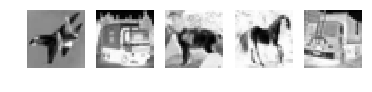

Predicted label for image 10 is [0] (airplane)
Correct label: airplane
Predicted label for image 11 is [1] (automobile)
Correct label: truck
Predicted label for image 12 is [1] (automobile)
Correct label: dog
Predicted label for image 13 is [2] (bird)
Correct label: horse
Predicted label for image 14 is [1] (automobile)
Correct label: truck


In [13]:
pred_data_iter = mx.io.NDArrayIter(data={'data': test_img[0:batch_size]}, batch_size=batch_size)
pred_digits    = mod.predict(eval_data=pred_data_iter).asnumpy()

%matplotlib inline

# starting index of items we want to predict
pred_start  = 10
# number of items we want to predict
pred_number = 5

for i in range(pred_number):
    plt.subplot(1,pred_number,i+1)
    plt.imshow(test_img[i + pred_start].reshape(32,32), cmap='Greys')
    plt.axis('off')
    
plt.show()

for x in range(pred_start, pred_start + pred_number):
    label = np.where(pred_digits[x,0:pred_number] == pred_digits[x,0:pred_number].max())[0]
    print("Predicted label for image %s is %s (%s)" % (x, label, label_names[label[0]]))
    print("Correct label:", label_names[test_lbl[x]])

# END OF THE FILE
Code below needs adjustments

### Downloading images for prediction from amazon.com

In [ ]:
urllib.request.urlretrieve('https://images-na.ssl-images-amazon.com/images/I/81OaXwn1x4L._UX679_.jpg', 'predict1.jpg')
urllib.request.urlretrieve('https://images-eu.ssl-images-amazon.com/images/I/31TcgNHsbIL._AC_UL260_SR200,260_.jpg', 'predict2.jpg')
urllib.request.urlretrieve('https://images-eu.ssl-images-amazon.com/images/I/41hWhZBIc3L._AC_UL260_SR200,260_.jpg', 'predict3.jpg')

### Load model from checkpoint for prediction

To load the saved module parameters, call the `mx.mod.load_checkpoint` function. It loads the symbolic definition of NN and all the associated parameters. We can then set the loaded parameters into the module.

In [ ]:
prediction_model_check_point = 10
prediction_model_prefix      = 'fashion_mnist'

prediction_sym, arg_params, aux_params = mx.model.load_checkpoint(prediction_model_prefix, prediction_model_check_point)
prediction_model = mx.mod.Module(symbol=prediction_sym, data_names=['fashion_data'], label_names=['fashion_item_label'])

Now we need to bind the model with new data- and label shapes and restore the parameter values. Since we want to make predictions for one image at a time, the data shape now must be (1,1,28,28), label shape - (1,)

In [ ]:
prediction_model.bind(for_training=False, data_shapes=[('fashion_data', (1,1,28,28))], label_shapes = [('fashion_item_label', (1,))])
prediction_model.set_params(arg_params=arg_params, aux_params=aux_params, allow_missing=True)

Now we define the **prediction function** `predict_fashion`, which:
- takes image as an input
- formats it to the needed shape (1, 28, 28), since now it must be a one-element dataset
- creates a trivial data iterator of batch size 1
- makes and prints predictions

In [ ]:
def predict_fashion(img):
    # format data to run prediction
    array = np.full((1, 28, 28), img, dtype=np.float32)
    pred_data_iter = mx.io.NDArrayIter(data={'fashion_data': to4d(array)}, batch_size=1)
    pred_digits = prediction_model.predict(eval_data=pred_data_iter).asnumpy()
    label = (np.where(pred_digits[0] == pred_digits[0].max())[0])
    print("Predicted fashion label for image is %s (%s)  " % (label,fashion_labels[label[0]]))

### Predict labels for downloaded images

Here we first load the image and then adjust it to the colours (with help of bit-wise inversion `cv2.bitwise_not` ) and to the size (with `skimage.transform.resize`) of the training dataset

In [ ]:
for i in range(3):
        img = mpimg.imread('predict'+str(i+1)+'.jpg')
        plt.imshow(img)
        plt.axis('off')
        plt.show() 
        # get colours in line with train data
        img = cv2.bitwise_not(img)
        img = np.array (np.mean(img, -1))

        # resize image
        img = skimage.transform.resize(img, (28, 28), mode ='reflect')

        predict_fashion(img)